# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

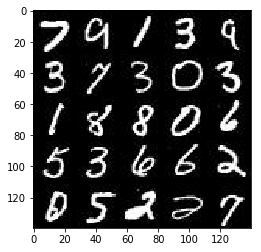

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

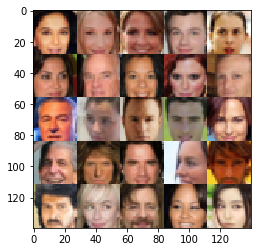

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
celeba_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(celeba_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [47]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [86]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # The input images are 28x28x(1 for MNIST, 3 for celeba)
        x1 = tf.layers.conv2d(images, 64, 5, 2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        # relu1 size is 14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, 2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        # relu2 size is 7x7x128
        
        x3 = tf.layers.conv2d(x2, 256, 5, 2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        # relu3 size is 4x4x256
        
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [93]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.1
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        x1 = tf.layers.dense(z, 2*2*512)
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # relu1 size is 4x4x256
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, 2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # relu3 size is 7x7x128
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, 2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # relu3 size is 14x14x64
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, 2, padding='same')
        out = tf.tanh(logits)
        # output size is 28x28xout_channel_dim
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [94]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # The loss of the descriminator is the sum of the losses for the real and the generated images.
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1-smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    # The generator losses depend only on the output from the discriminator for the generated images.
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [95]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # The updates for the generator and the discriminator must be done separately.
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(d_vars):
        d_optim = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(g_vars): 
        g_optim = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
    
    
    return g_optim, d_optim

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [57]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [98]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_optim, g_optim = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images = batch_images * 2.0
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_optim, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_optim, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                
                steps += 1
                
                if steps % 100 == 0:
                    # Print losses and some other info
                    g_train_loss = g_loss.eval({input_z: batch_z, input_real: batch_images})
                    d_train_loss = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    print("Epoch: {} - Steps: {}".format(epoch_i, steps))
                    print("Generator loss: {}".format(g_train_loss))
                    print("Discriminator loss: {}".format(d_train_loss))
                    
                    # Print last generated image
                    _ = show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch: 0 - Steps: 100
Generator loss: 5.359823226928711
Discriminator loss: 0.5328999161720276


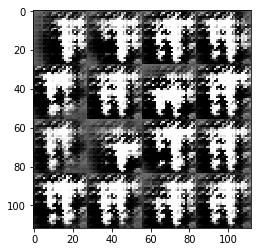

Epoch: 0 - Steps: 200
Generator loss: 5.0513505935668945
Discriminator loss: 0.756306529045105


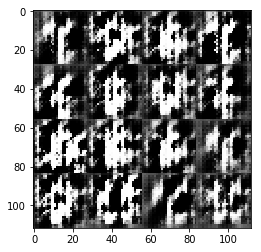

Epoch: 0 - Steps: 300
Generator loss: 1.1037359237670898
Discriminator loss: 0.966773509979248


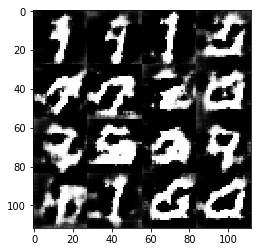

Epoch: 0 - Steps: 400
Generator loss: 2.194385528564453
Discriminator loss: 0.9168778657913208


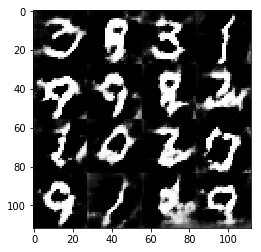

Epoch: 0 - Steps: 500
Generator loss: 0.6049050092697144
Discriminator loss: 1.2258669137954712


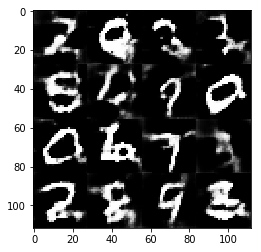

Epoch: 0 - Steps: 600
Generator loss: 0.7529569268226624
Discriminator loss: 1.120550274848938


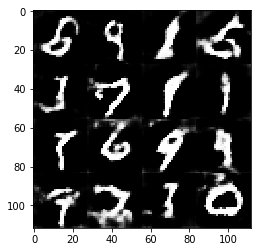

Epoch: 0 - Steps: 700
Generator loss: 1.5345759391784668
Discriminator loss: 0.848554253578186


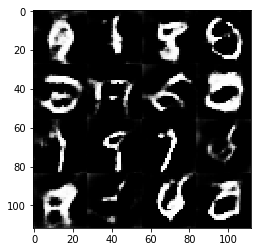

Epoch: 0 - Steps: 800
Generator loss: 2.0754711627960205
Discriminator loss: 1.1652851104736328


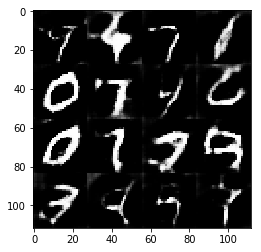

Epoch: 0 - Steps: 900
Generator loss: 0.7918642163276672
Discriminator loss: 1.038399577140808


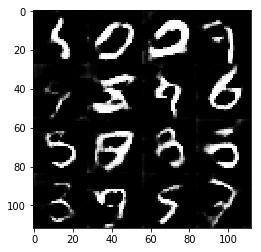

Epoch: 0 - Steps: 1000
Generator loss: 1.2327979803085327
Discriminator loss: 0.8956273794174194


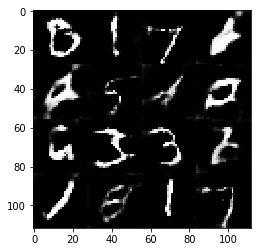

Epoch: 0 - Steps: 1100
Generator loss: 1.3748186826705933
Discriminator loss: 0.9858108758926392


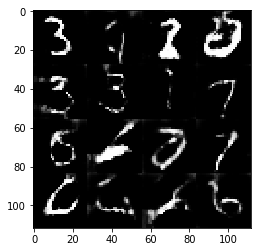

Epoch: 0 - Steps: 1200
Generator loss: 0.9647111296653748
Discriminator loss: 0.9623761773109436


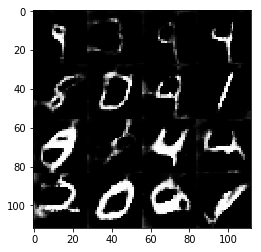

Epoch: 0 - Steps: 1300
Generator loss: 1.7051154375076294
Discriminator loss: 0.8303201198577881


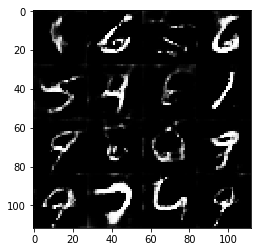

Epoch: 0 - Steps: 1400
Generator loss: 1.1229010820388794
Discriminator loss: 0.8569932579994202


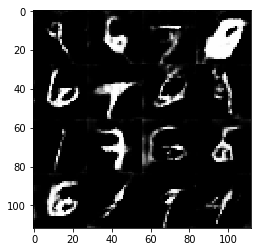

Epoch: 0 - Steps: 1500
Generator loss: 1.0160596370697021
Discriminator loss: 1.017622709274292


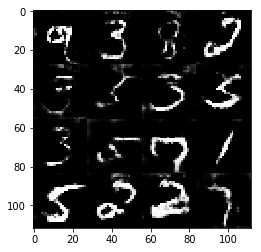

Epoch: 0 - Steps: 1600
Generator loss: 1.7119460105895996
Discriminator loss: 1.209760308265686


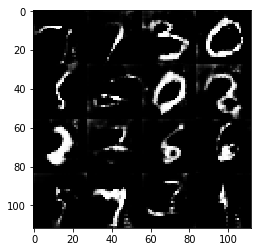

Epoch: 0 - Steps: 1700
Generator loss: 1.7937320470809937
Discriminator loss: 0.9924005270004272


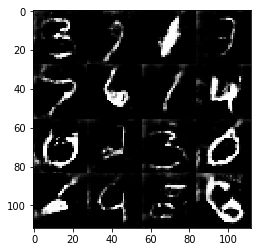

Epoch: 0 - Steps: 1800
Generator loss: 0.9156497716903687
Discriminator loss: 0.958895206451416


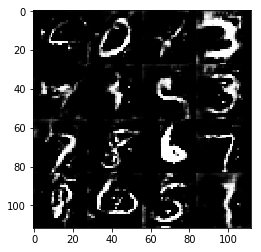

Epoch: 1 - Steps: 1900
Generator loss: 1.744866132736206
Discriminator loss: 0.9216085076332092


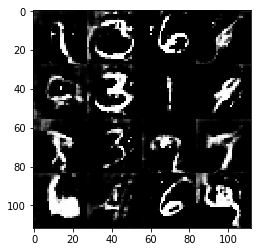

Epoch: 1 - Steps: 2000
Generator loss: 1.4234485626220703
Discriminator loss: 0.9275486469268799


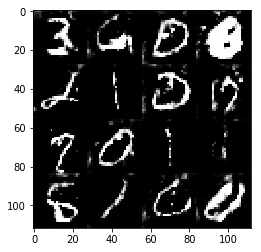

Epoch: 1 - Steps: 2100
Generator loss: 1.4641530513763428
Discriminator loss: 1.040555715560913


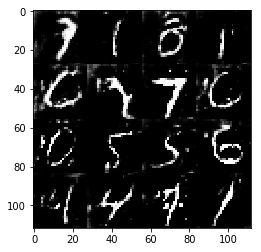

Epoch: 1 - Steps: 2200
Generator loss: 1.6278067827224731
Discriminator loss: 1.0437251329421997


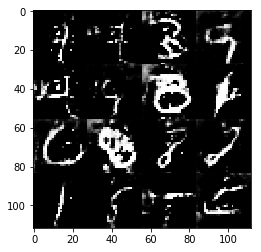

Epoch: 1 - Steps: 2300
Generator loss: 1.286882996559143
Discriminator loss: 0.8890421986579895


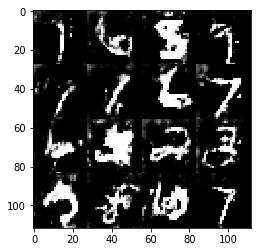

Epoch: 1 - Steps: 2400
Generator loss: 0.7451647520065308
Discriminator loss: 1.0703803300857544


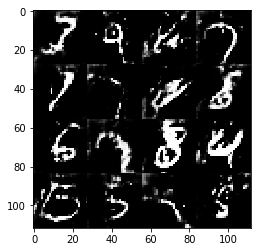

Epoch: 1 - Steps: 2500
Generator loss: 0.8025810718536377
Discriminator loss: 1.0405023097991943


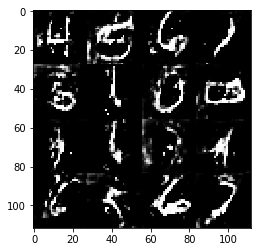

KeyboardInterrupt: 

In [99]:
batch_size = 32
z_dim = 100
learning_rate = 0.0015
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch: 0 - Steps: 100
Generator loss: 1.882899284362793
Discriminator loss: 0.8129100799560547


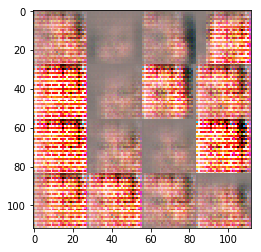

Epoch: 0 - Steps: 200
Generator loss: 1.4723176956176758
Discriminator loss: 1.1591548919677734


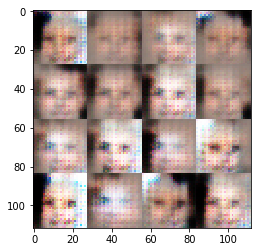

Epoch: 0 - Steps: 300
Generator loss: 1.1883728504180908
Discriminator loss: 1.1194384098052979


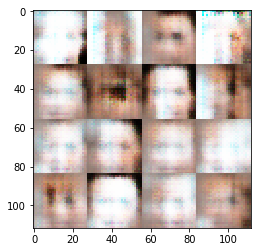

Epoch: 0 - Steps: 400
Generator loss: 1.3811265230178833
Discriminator loss: 1.3766748905181885


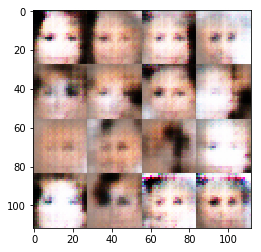

Epoch: 0 - Steps: 500
Generator loss: 3.2177839279174805
Discriminator loss: 1.758245587348938


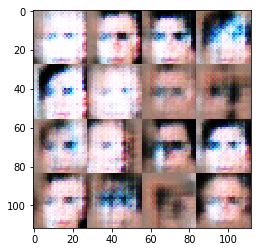

Epoch: 0 - Steps: 600
Generator loss: 1.6978667974472046
Discriminator loss: 1.0220798254013062


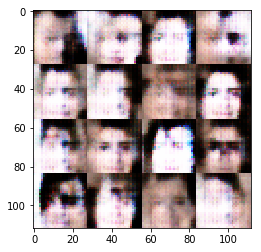

Epoch: 0 - Steps: 700
Generator loss: 1.1124331951141357
Discriminator loss: 0.8305178880691528


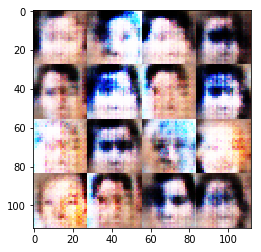

Epoch: 0 - Steps: 800
Generator loss: 1.7970101833343506
Discriminator loss: 0.9537039399147034


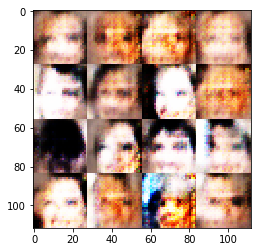

Epoch: 0 - Steps: 900
Generator loss: 1.2510836124420166
Discriminator loss: 1.0127125978469849


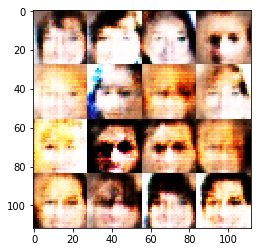

Epoch: 0 - Steps: 1000
Generator loss: 0.8212153911590576
Discriminator loss: 1.0957810878753662


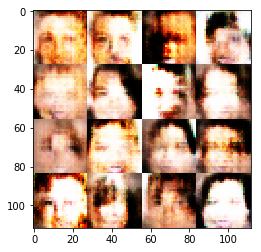

Epoch: 0 - Steps: 1100
Generator loss: 1.0958951711654663
Discriminator loss: 0.9913474321365356


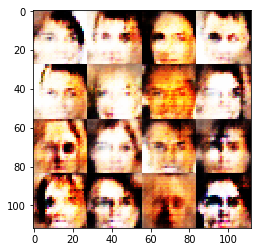

Epoch: 0 - Steps: 1200
Generator loss: 1.2405294179916382
Discriminator loss: 1.0572338104248047


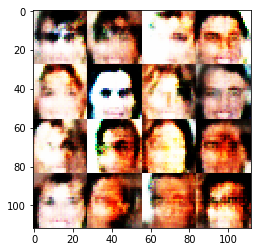

Epoch: 0 - Steps: 1300
Generator loss: 1.285426139831543
Discriminator loss: 1.0269633531570435


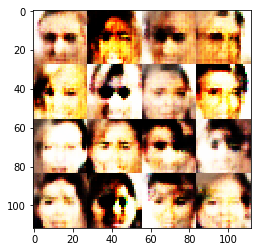

Epoch: 0 - Steps: 1400
Generator loss: 0.9622334837913513
Discriminator loss: 0.9977357983589172


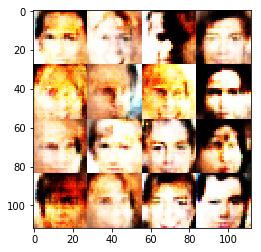

Epoch: 0 - Steps: 1500
Generator loss: 1.4886813163757324
Discriminator loss: 0.964173436164856


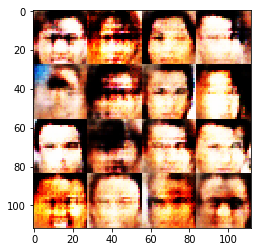

Epoch: 0 - Steps: 1600
Generator loss: 1.406205177307129
Discriminator loss: 0.9330242872238159


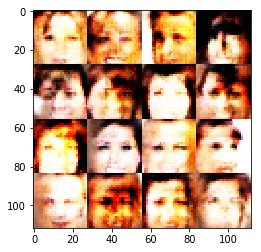

Epoch: 0 - Steps: 1700
Generator loss: 1.6903424263000488
Discriminator loss: 1.1380646228790283


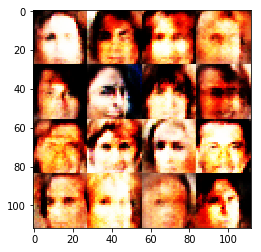

Epoch: 0 - Steps: 1800
Generator loss: 1.3121157884597778
Discriminator loss: 0.9442691206932068


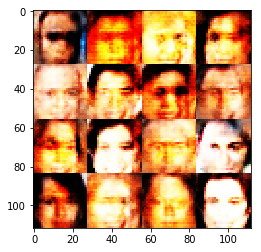

Epoch: 0 - Steps: 1900
Generator loss: 1.5345466136932373
Discriminator loss: 1.0257482528686523


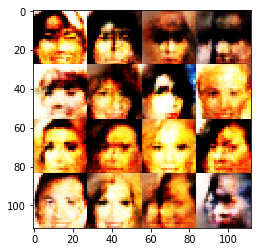

Epoch: 0 - Steps: 2000
Generator loss: 1.1300581693649292
Discriminator loss: 1.0525927543640137


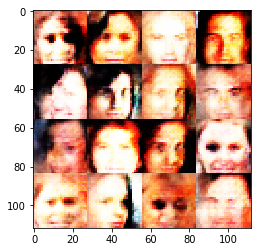

Epoch: 0 - Steps: 2100
Generator loss: 0.988715410232544
Discriminator loss: 1.0941200256347656


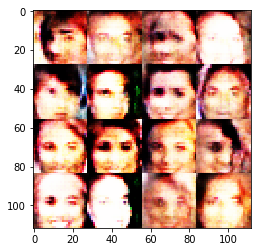

Epoch: 0 - Steps: 2200
Generator loss: 1.1756700277328491
Discriminator loss: 0.8730790615081787


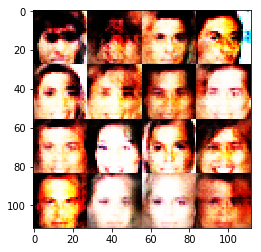

Epoch: 0 - Steps: 2300
Generator loss: 1.0905423164367676
Discriminator loss: 1.0104646682739258


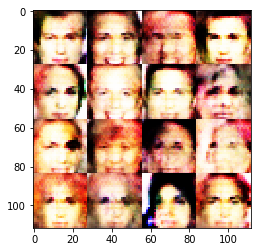

Epoch: 0 - Steps: 2400
Generator loss: 1.5678468942642212
Discriminator loss: 1.008914589881897


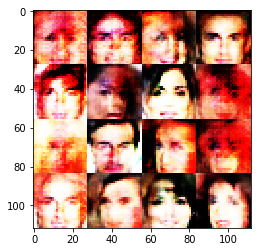

Epoch: 0 - Steps: 2500
Generator loss: 1.493666410446167
Discriminator loss: 1.1226952075958252


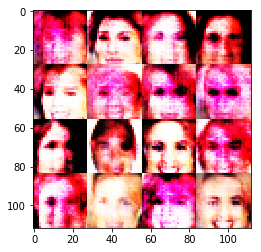

Epoch: 0 - Steps: 2600
Generator loss: 1.500680923461914
Discriminator loss: 1.09031081199646


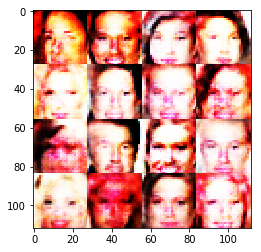

Epoch: 0 - Steps: 2700
Generator loss: 1.2146496772766113
Discriminator loss: 1.1339507102966309


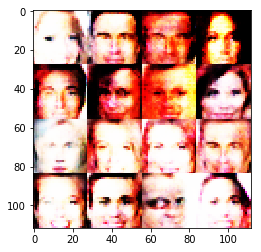

Epoch: 0 - Steps: 2800
Generator loss: 1.4742441177368164
Discriminator loss: 1.0747065544128418


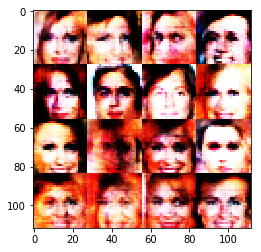

Epoch: 0 - Steps: 2900
Generator loss: 1.4641685485839844
Discriminator loss: 0.987810492515564


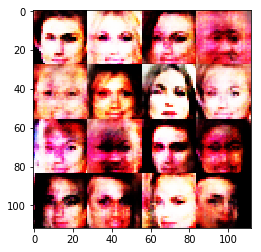

Epoch: 0 - Steps: 3000
Generator loss: 0.7605050206184387
Discriminator loss: 1.3287994861602783


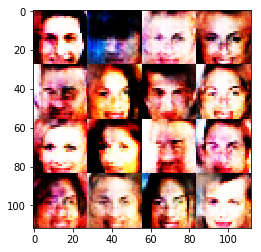

Epoch: 0 - Steps: 3100
Generator loss: 1.346731424331665
Discriminator loss: 1.0767995119094849


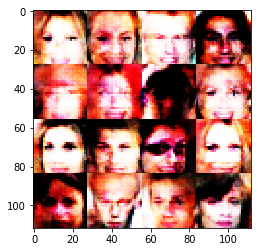

In [101]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.